# Week3 심화과제 : Ner

## 1 [My Code] Preparation

### 1.1 [My Code] Dataset Load

In [8]:
import kagglehub
import chardet
from pathlib import Path
import pandas as pd
import torch

path = kagglehub.dataset_download("debasisdotcom/name-entity-recognition-ner-dataset")
dir = Path(path)
path_lst = [path for path in dir.rglob('*')]
data_path = path_lst[0]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# 캐글 데이터셋이 인코딩 정보가 일반적이지 않아 load과정에서 다음 인코딩을 검출하야 로드드
with open(data_path, 'rb') as file:
    encoding = chardet.detect(file.read())

### 1.2 [My Code] Model Config

In [9]:
learning_rate=2e-5
per_device_train_batch_size=16
per_device_eval_batch_size=16
# 테스트 환경에선 3에폭만 진행합니다.
num_train_epochs=3
weight_decay=0.01

### 1.3 [My Code] 데이터셋 설명

In [10]:
# 데이터셋입니다.
# 테스트 환경에선 1000개 샘플만 수행합니다. 
df = pd.read_csv(data_path, encoding='Windows-1252').iloc[:1000]

In [11]:

# ner과 pos에 대한 설명이 있는 파일입니다. 
ner_df = pd.read_csv("data/NER_tags.csv")
ner_unique = list(ner_df['NER 태그'][1:].apply(lambda x: x.split('-')[1]).unique())
ner_unique.append("O")
index_result = []
for unique_tag in ner_unique:
    for i, tag in enumerate(ner_df['NER 태그'].to_list()):
        if len(tag) > 1 and unique_tag==tag.split('-')[1]:
            index_result.append(i)

        elif len(tag) == 1 and unique_tag==tag:
            index_result.append(i)
        

ner_df = ner_df.iloc[index_result].reset_index(drop=True)
pos_df = pd.read_csv("data/POS_tags.csv")

In [12]:
from IPython.display import display
display(ner_df[['NER 태그','설명']])
print()
display(pos_df[['POS 태그','설명']])

,NER 태그,설명
0,B-geo,위치(지리적 개체)의 시작
1,I-geo,위치(지리적 개체)의 내부
2,B-tim,시간 표현의 시작
3,I-tim,시간 표현의 내부
4,B-org,조직(Organization)의 시작
5,I-org,조직(Organization)의 내부
6,I-per,사람(Person)의 내부
7,B-per,사람(Person)의 시작
8,B-gpe,정치적/지리적 단위의 시작
9,I-gpe,정치적/지리적 단위의 내부


,POS 태그,설명
0,NN,단수 일반 명사
1,NNP,단수 고유 명사
2,IN,전치사
3,DT,한정사(관사)
4,JJ,형용사
5,NNS,복수 일반 명사
6,.,마침표
7,VBD,과거형 동사
8,",",쉼표
9,VBN,과거분사


In [13]:
import pandas as pd
id2label = {index: value for index, value in ner_df['NER 태그'].items()}
label2id = {value: index for index, value in ner_df['NER 태그'].items()}
label_list = list(label2id.keys())
df['Tag'] = df['Tag'].apply(lambda x: label2id[x] if not pd.isnull(x) else x)

### 1.4 [My Code] EDA - Label distribution

In [14]:
# 16번 태그(기타)가 84% 이상임을 알 수 있다.
# 따라서 모델 설계를 해서 metric이 84$ 이상 나와야 유효한 모델임을 유추할 수 있다.
# 모두 16번만 찍어도 84%가 accuracy로 찍히는 라벨 불균형 상태이기 때문이다.
proportin_df = pd.DataFrame(df['Tag'].value_counts(normalize=True).sort_index())
display(proportin_df)

,proportion
Tag,
0,0.033
1,0.008
2,0.012
4,0.020
5,0.021
6,0.008
7,0.007
8,0.028
10,0.001


## 2 [My Code] Train

### 2.1 [My Code] Model Load

In [15]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, ModernBertModel
import torch
model_id = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForTokenClassification.from_pretrained(
    model_id, 
    num_labels=len(label_list), 
    id2label=id2label,
    label2id=label2id
    )

for param in model.distilbert.parameters():
    param.requires_grad = False

model = model.to(device)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 2.2 [My Code] Data Preprocessing

In [16]:
import numpy as np
index_lst = [i for i, row in df.iterrows() if not pd.isna(row['Sentence #'])]

index_lst = np.array(df[~df['Sentence #'].apply(lambda x: pd.isna(x))].index)
index_lst = np.append(index_lst, len(df))
start_index = index_lst[:-1]
end_index = index_lst[1:]

result = []
for start, end in zip(start_index, end_index):
    data = df.iloc[start:end]
    result.append(data)
    
x_list = []
y_list = []
for data in result:
    token_lst = data['Word'].to_list()
    label_lst = data['Tag'].to_list()
    if not (any(pd.isnull(x) for x in token_lst) or any(pd.isnull(x) for x in label_lst)):
        x_list.append(token_lst)
        y_list.append(label_lst)
index_lst = list(range(len(x_list)))

In [17]:
from datasets import Dataset, DatasetDict, Features, Value, Sequence

dataset_dict = {
    'id': index_lst,
    'tokens': x_list,
    'ner_tags': y_list,
}
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['id', 'tokens', 'ner_tags'],
    num_rows: 43
})

In [18]:
def tokenize_and_align_labels(examples):
    # samples의 첫번째는 토큰이 29개입니다. 따라서 라벨도 29개가 나와야 합니다.
    samples = examples

    # 첫번째 샘플의 input_ids의 수는 41입니다. 즉 토큰화된 것을 한 번 더 토크나이징 하는 것입니다. 
    tokenized_inputs  = tokenizer(samples['tokens'], truncation=True, is_split_into_words=True)
    labels = []
    for i, label in enumerate(samples['ner_tags']):

        # 한 문장 내에서 토큰이 몇 번째 단어에 매핑되는지 알려줍니다. 
        # None은 CLS와 SEP으로 매핑됩니다.
        # input_ids의 수가 41이기 때문에, 라벨 또한 41로 늘려야 합니다. 
        # 현재는 29개이기 때문에 아래의 logic을 거치는 것입니다.
        word_ids = tokenized_inputs.word_ids(batch_index = i)
        previous_word_idx = None
        label_ids = []

        # 아래 로직은 다음 역할을 합니다.
        # cls와 sep엔 -100을 부여합니다.
        # 한 단어에서 잘려나온 토큰에 대해선 첫 번째 토큰을 제외한 나머지 토큰에 대해 -100을 부여합니다.
        # 그 외의 모든 토큰에 대해선 라벨 값을 그대로 사용합니다.
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True)
tokenized_dataset

Map:   0%|          | 0/43 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 43
})

In [19]:
train_val_test_split = tokenized_dataset.train_test_split(test_size=0.1)
train_val_dataset = train_val_test_split['train']
test_dataset = train_val_test_split['test']

train_val_split = train_val_dataset.train_test_split(test_size=0.13)
train_dataset = train_val_split['train']
val_dataset = train_val_split['test']

dataset_input = DatasetDict({
    'train':train_dataset,
    'val':val_dataset,
    'test':test_dataset,
})
dataset_input

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 33
    })
    val: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 5
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 5
    })
})

## 2.3 [My Code] Data Collator

In [20]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

### 2.4 [My Code] metric

In [21]:
import evaluate

seqeval = evaluate.load("seqeval")

## 2.5 [My Code] Metric function

In [22]:
import numpy as np

labels = [label_list[i] for i in dataset_input['train'][0][f"ner_tags"]]


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels,  zero_division=0)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

### 2.6 [Log] Train

In [23]:
from transformers import TrainingArguments, Trainer
import torch._dynamo
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
torch._dynamo.config.suppress_errors = True

training_args = TrainingArguments(
    output_dir=".results/week3_advanced_ner",
    learning_rate=learning_rate,
    per_device_train_batch_size=per_device_train_batch_size,
    per_device_eval_batch_size=per_device_eval_batch_size,
    num_train_epochs=num_train_epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy='epoch',
    logging_strategy="epoch",
    logging_dir=".results/week3_advanced_ner",
    load_best_model_at_end=True,
    push_to_hub=False,
    report_to='none'
)

trainer = Trainer(
    model=model, 
    args=training_args,
    train_dataset=dataset_input["train"],
    eval_dataset=dataset_input["val"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [24]:
from pprint import pprint
initial_metrics = trainer.predict(dataset_input["test"])

In [25]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Precision,Recall,F1,Accuracy
1,2.988100,2.925378,0.000800,0.013333,0.076923,0.022727,0.017699
2,2.937400,2.918892,0.000800,0.013333,0.076923,0.022727,0.017699
3,2.957400,2.916306,0.000800,0.013333,0.076923,0.022727,0.017699


TrainOutput(global_step=9, training_loss=2.960975752936469, metrics={'train_runtime': 1.5147, 'train_samples_per_second': 65.36, 'train_steps_per_second': 5.942, 'total_flos': 1084816945500.0, 'train_loss': 2.960975752936469, 'epoch': 3.0})

In [26]:
from pprint import pprint
metrics = trainer.predict(dataset_input["test"])

In [27]:
initial_metrics = initial_metrics[-1]
metrics = metrics[-1]

## 3 [My Code] Plot

[2.9881, 2.9374, 2.9574] [2.925377607345581, 2.9188923835754395, 2.9163060188293457] [0.017699115044247787, 0.017699115044247787, 0.017699115044247787] [0.02272727272727273, 0.02272727272727273, 0.02272727272727273] 2.957855701446533 0.02 0.0





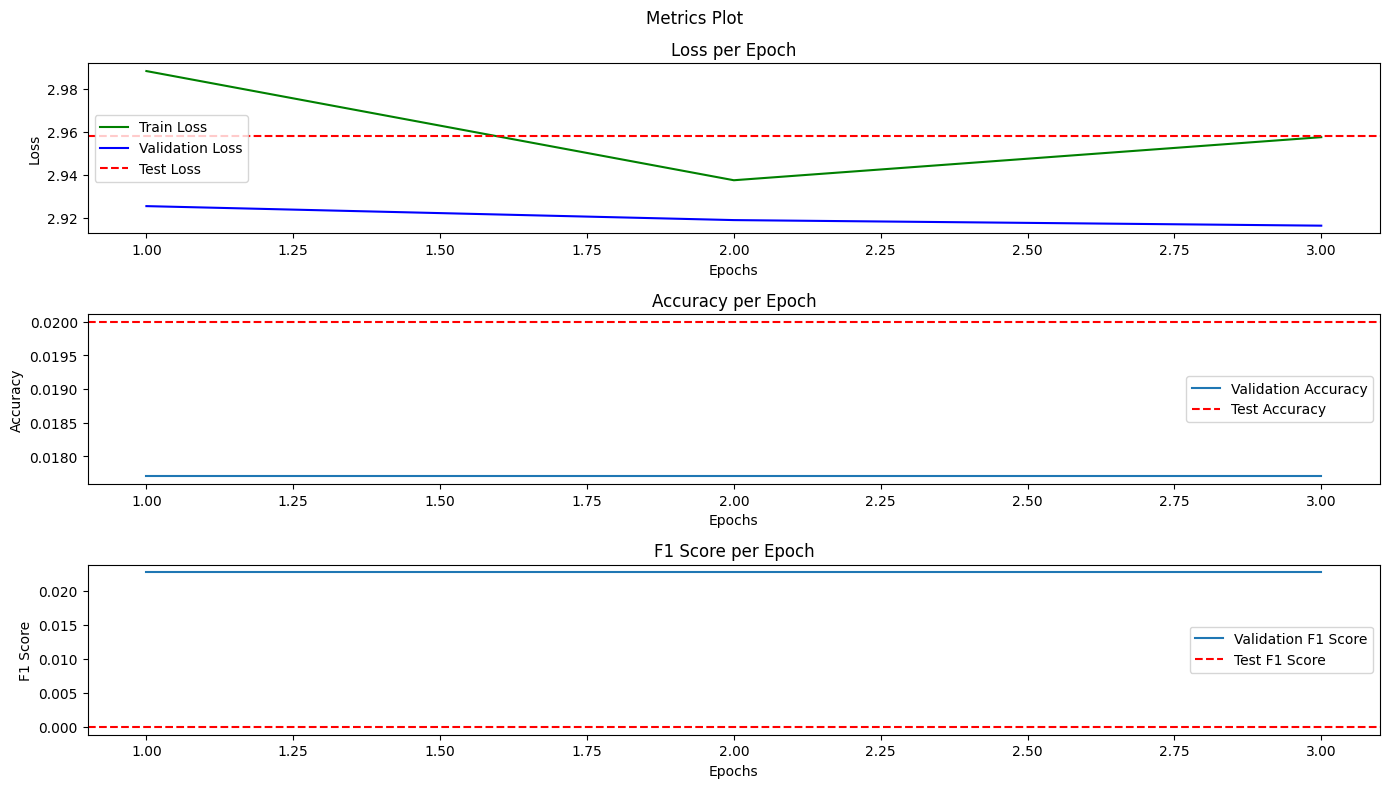

In [28]:
import matplotlib.pyplot as plt

def plotting():
    # 로그 데이터 추출
    log_history = trainer.state.log_history

    # 메트릭 초기화
    epochs = []
    train_loss = []
    val_loss = []
    val_accuracy = []
    val_f1 = []

    # 로그 데이터 분리
    for log in log_history:
        if 'epoch' in log:
            current_epoch = log['epoch']
            if current_epoch not in epochs:
                epochs.append(current_epoch)
            if 'loss' in log:
                train_loss.append(log['loss'])
            if 'eval_loss' in log:
                val_loss.append(log['eval_loss'])
            if 'eval_accuracy' in log:
                val_accuracy.append(log['eval_accuracy'])
            if 'eval_f1' in log:
                val_f1.append(log['eval_f1'])

    test_loss = metrics['test_loss']
    test_accuracy = metrics['test_accuracy']
    test_f1 = metrics['test_f1']


    print(train_loss, val_loss, val_accuracy, val_f1, test_loss, test_accuracy, test_f1)

    # 플로팅
    plt.figure(figsize=(14, 8))

    # 손실 플롯
    plt.subplot(3, 1, 1)
    plt.plot(epochs, train_loss, color = 'g', label='Train Loss')
    plt.plot(epochs, val_loss, color = 'b', label='Validation Loss')
    plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    # 정확도 및 F1 스코어 플롯
    plt.subplot(3, 1, 2)
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(epochs, val_f1, label='Validation F1 Score')
    plt.axhline(y=test_f1, color='r', linestyle='--', label='Test F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('F1 Score per Epoch')
    plt.legend()

    plt.suptitle(f"Metrics Plot")
    plt.tight_layout()
    print("\n\n")

plotting()
plt.show()

## 4 [My Code] Conclusion

In [29]:
import pandas as pd
# initial metric과 훈련 이후의 metric을 비교합니다.
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 학습 가능한 파라미터 수 출력
trainable_params_lst = [count_trainable_parameters(model) ]
train_runtime_lst = [trainer.state.log_history[-1]['train_runtime']]


result_df = pd.DataFrame([metrics])
result_df.index = ["model"]
result_df['trainable_parameters']  = trainable_params_lst
result_df['train_runtime'] = train_runtime_lst
initial_row = pd.DataFrame([initial_metrics])[["test_loss",'test_accuracy','test_f1']]
initial_row.index = ["initial_model"]
result_df = pd.concat([result_df, initial_row], axis=0).fillna("")
display(result_df[['test_loss','test_accuracy','test_f1','trainable_parameters', 'train_runtime', 'test_runtime']])

,test_loss,test_accuracy,test_f1,trainable_parameters,train_runtime,test_runtime
model,2.957856,0.02,0.0,13073.0,1.5147,0.016
initial_model,2.979023,0.02,0.0,,,
